In [1]:
import numpy as npimport numpy as np
import pandas as pd
from minisom import MiniSom
from collections import Counter

import matplotlib.cm  as cm
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_predict


import sys, os
sys.path.append('..')
from utils import data_preprocesados, etiquetas, LP_datos, plot_LP_list

 instala AntroPy [https://raphaelvallat.com/antropy] pip3 install antropy


In [2]:
X_all = data_preprocesados(2, n_components=5)

[0.35839694 0.2125936  0.08712974 0.06979471 0.06568434] 0.7935993420974992


Del cuaderno anterior aprendimos que podemos identificar entre 4 y 5 grandes clusters para clasificar las señales.
En este cuaderno vamos a combinar los algortimos TSNE y GMM para visualizar y seleccionar aquellas señales que pertenezcan (con una alta probabilidad) a una clase definida. De esta forma vamos a poder comparar señales y clasificar manualmente para tener algunas etiquetas.

## 1. TSNE + GMM

In [3]:
tsne = TSNE(init='pca', learning_rate='auto')
X_valid_2D = tsne.fit_transform(X_all)

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [4]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
labels = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)

print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')
print('\n', Counter(labels))

 Akaike information criterion (AIC):  17283
 Bayesian information criterion (BIC):  17486

 Counter({5: 218, 3: 172, 2: 160, 4: 152, 1: 136, 6: 106, 0: 100})


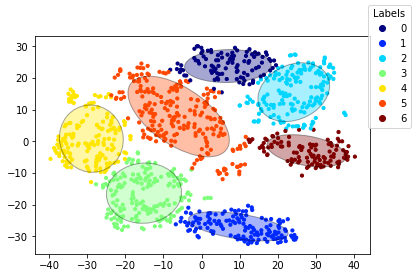

In [5]:
norm = mcolors.Normalize(0, n-1)
fig, ax = plt.subplots(1,1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')


# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)


C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


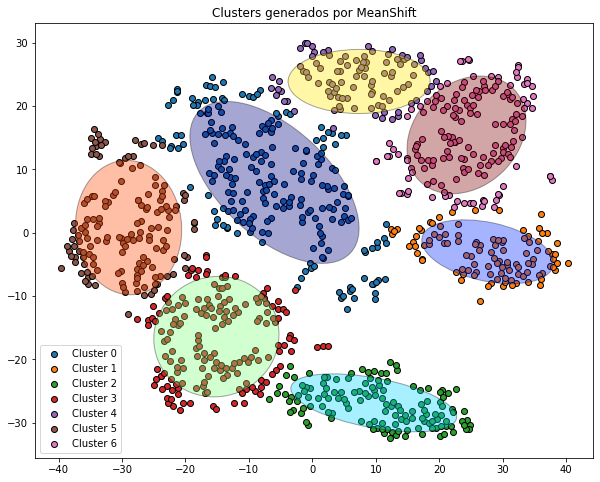

In [6]:
tsne = TSNE(init='pca', learning_rate='auto')
X_valid_2D_1 = tsne.fit_transform(X_all)

n = 7
gmm = GaussianMixture(n_components=n, n_init=10)
gmm.fit(X_valid_2D_1)
labels = gmm.predict(X_valid_2D_1)
prob = gmm.predict_proba(X_valid_2D_1)

y_predict = gmm.fit_predict(X_valid_2D_1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Clusters generados por MeanShift')
ax.legend();


for i in np.unique(y_predict):
    ax.scatter(
        x = X_valid_2D_1[y_predict == i, 0],
        y = X_valid_2D_1[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

# plot ellipses
for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = mpatch.Ellipse(mean, v[0], v[1], 180.0 + angle, ec='k', color=cm.get_cmap('jet')(norm(n)))
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.35)
    ax.add_artist(ell)

ax.legend()

In [10]:
index, best_label = np.where(prob>0.999)

dlabel = Counter(best_label)
n_labels = list(dlabel.keys())
n_labels.sort()

print(f'Total: {len(index)}') 
print('Label, nro_LPs')
print('---------------')
for n in n_labels:
    i = dlabel[n]
    print(f'{n:^5}', f'{i:^7}')

Total: 115
Label, nro_LPs
---------------
  1     63   
  3     20   
  4     19   
  5     13   


[1043  659  626]


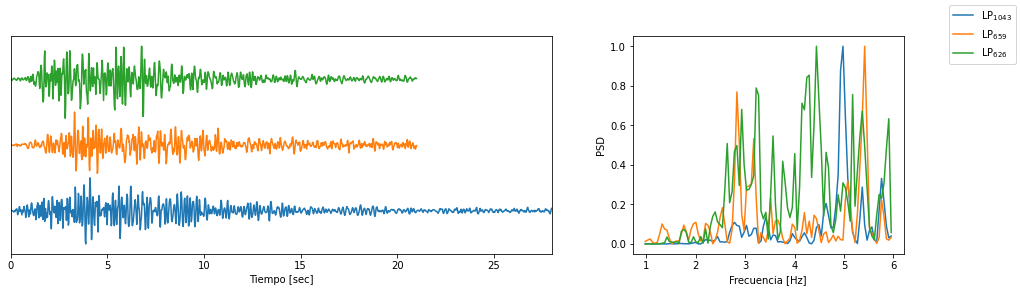

In [11]:
k_label = 3
n_LPs = 3
gen = LP_datos()

k_index = index[np.where(best_label==k_label)]
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))


Hemos tenido que reducir el tamaño en el GMM para ir buscando señales parecidas.

Los resultados son prometedores y nos ha permitido emparejar 97 señales de LP en 15 etiquetas.

In [12]:
idx, y_valid = etiquetas()
print('Supervised labels: ', len(y_valid))
print('Sup_label, nro_LPs')
print('------------------')
nlabel = Counter(y_valid)
dlabel = list(nlabel.keys())
dlabel.sort()
for n in dlabel:
    i = nlabel[n]
    print(f'{n:^9}', f'{i:^7}')

Supervised labels:  97
Sup_label, nro_LPs
------------------
    1       28   
    2       10   
    3        4   
    4       30   
    5        3   
    6        3   
    7        2   
    8        3   
    9        2   
   10        2   
   11        2   
   12        2   
   13        2   
   14        2   
   15        2   


[324 175 142]


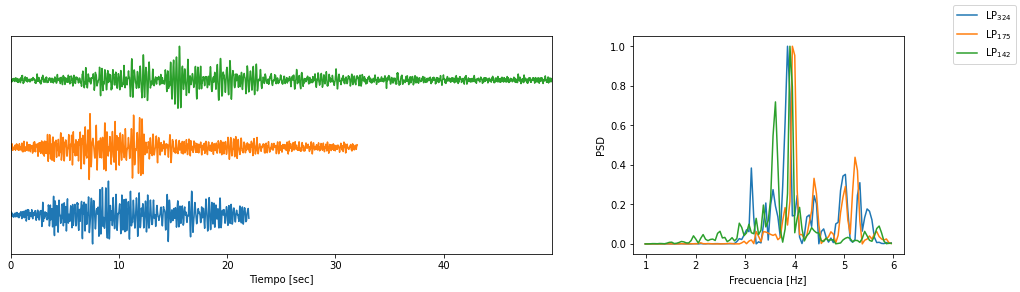

In [13]:
# veamos algunos ejemplos
k_index = np.array(idx)[np.where(np.array(y_valid)==2)]
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))


Establecer estas etiquetas no fue sencillo, primero tuvimos que ir comparando entre pares de señales. Cuando estás se daban, se iban guardando. Luego diseñar codigos sencillos que juntaran indices repetidos con el fin de hacer cadenas largas de índices de señales de una misma clase.

Aún así es posible que errores hayan podido cometerse durante esta parte. La complejidad de las comparación es tal que cuando se visualiza el resultado es posible que señales con una misma etiqueta no resulten tan parecidos como uno esperaría.

In [14]:
n_LP_toshow = 10
sup_label = 1
k_sup_index = np.array(idx)[np.where(np.array(y_valid)==sup_label)] # resultados supervisados
k_sup_index_rand = k_sup_index[np.random.choice(k_sup_index.shape[0], n_LP_toshow, replace=False)]

print('supervised_label: ', sup_label)
print('LP_index,  GMM_label')
print('-------------------')
for kid in k_sup_index_rand:
    print(f'{kid:^8}', '   ', labels[kid])


supervised_label:  1
LP_index,  GMM_label
-------------------
  510        1
  624        1
  959        6
   6         2
  476        4
  872        3
  284        2
  315        6
  1012       6
  313        5


In [15]:
print('Sup_label   gmm_label:n_Lps')
print('----------------------')
for i in dlabel:
    k_sup_index = np.array(idx)[np.where(np.array(y_valid)==i)]
    gmm_labels = Counter([labels[kid] for kid in k_sup_index])

    print(f'{i:^9}', dict(gmm_labels))

Sup_label   gmm_label:n_Lps
----------------------
    1     {2: 5, 6: 11, 5: 4, 4: 1, 1: 5, 3: 2}
    2     {6: 9, 5: 1}
    3     {2: 1, 1: 2, 6: 1}
    4     {2: 6, 5: 14, 6: 9, 3: 1}
    5     {6: 1, 1: 1, 0: 1}
    6     {6: 2, 0: 1}
    7     {6: 1, 2: 1}
    8     {1: 1, 4: 2}
    9     {1: 1, 5: 1}
   10     {6: 1, 5: 1}
   11     {6: 2}
   12     {6: 2}
   13     {5: 1, 1: 1}
   14     {1: 2}
   15     {1: 2}


Estos resultados no son muy prometedores, pero dado que nuestro esfuerzo por etiquetar manualmente las señales por inspección visual tampoco arroja resultados correctos. Vamos a considerar que el modelo GMM logra clasificar bien en familias una gran parte del dataset.

De echo, si tenemos en cuenta unicamente aquellos LPs con prob de pertenencia por arriba del 99.9%, 376 señales (36%) estarían etiquetadas,
esto nos va a permitir entrenar clasificadores 

## 2. LogisticRegrsion / Propagacion de etiquetas

In [13]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

n = 7
gmm = GaussianMixture(n_components=n, n_init=10).fit(X_valid_2D)
y_prob = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
LP_index, Y_labeled = np.where(prob>0.999)

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [14]:
X_labeled = np.empty((len(LP_index), X_all.shape[1]))
X_forlabel = np.empty((X_all.shape[0]-len(LP_index), X_all.shape[1]))
y_forlabel = []

nl = 0
nf = 0
for n in range(X_all.shape[0]):
    if n in LP_index:
        X_labeled[nl,:] = X_all[n,:]
        nl += 1
    else:
        X_forlabel[nf,:] = X_all[n,:]
        y_forlabel.append(np.argmax(prob[n]))
        nf += 1

In [15]:
print('Total: ', X_labeled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, Y_labeled, test_size=0.25, random_state=15)
print('Entrenamiento: ', X_train.shape) 
print('Validación: ',X_test.shape)

Total:  (346, 16)
Entrenamiento:  (259, 16)
Validación:  (87, 16)


Recall:  0.99
Precision:  0.99
[[ 5  0  0  0  0  0]
 [ 0 29  0  0  0  0]
 [ 0  0 32  0  0  0]
 [ 0  0  0 98  0  0]
 [ 0  0  0  0 19  2]
 [ 0  0  0  0  0 74]]


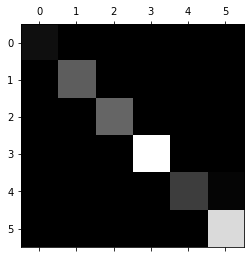

In [16]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=1.0)
lr.fit(X_train, y_train)
y_train_pred_CG = cross_val_predict(lr, X_train, y_train, cv=5)
conf_cm = confusion_matrix(y_train, y_train_pred_CG)
plt.matshow(conf_cm, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print(conf_cm)

El modelo es muy preciso y practicamente no se equivoca, pero ¿generalizara bien?

[[ 3  0  0  0  0  0]
 [ 0 14  0  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  0 41  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  0 17]]
Recall:  1.00
Precision:  1.00


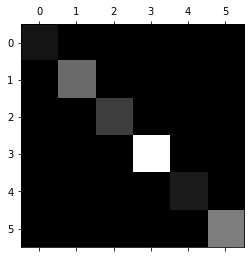

In [17]:
conf_cm_test = confusion_matrix(y_test, lr.predict(X_test))
print(conf_cm_test)
plt.matshow(conf_cm_test, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_test, lr.predict(X_test), average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_test, lr.predict(X_test), average='weighted'):.2f}")

Pues parece que generaliza muy bien. 

Vamos a ver si es capaz de clasificar las demas señales y vamos a comparar con el GMM

[[ 25   0   0   0  12  16   0]
 [  0  61   0  37   0   0   0]
 [  0   1  85   0   2   0   0]
 [  1   0   1 154   0   0   0]
 [  0   3   9   1  76   1   0]
 [  0   0   6   0   0  42   0]
 [  2   1  59  96   7   0   0]]


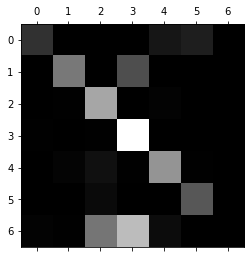

In [18]:
y_result = lr.predict(X_forlabel)
conf_cm_gmm = confusion_matrix(y_forlabel, y_result)
print(conf_cm_gmm)
plt.matshow(conf_cm_gmm, cmap='Greys_r')


Hay una etiqueta que falla que tiene que ver con la poca de densidad de datos. 
Por otro lado, vemos que el clasificador podría andar bien

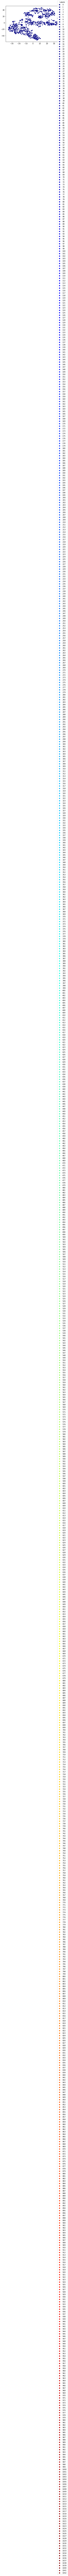

In [19]:
norm = mcolors.Normalize(0, n-1)
fig, ax = plt.subplots(1,1)
ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=labels, cmap='jet', norm=norm, s=10)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(n)]
fig.legend(h, range(n), title='Labels')

## 3. Validación visual